In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import r2_score


%matplotlib inline
pd.options.display.max_columns = None

C:\Users\erikl\Anaconda2\envs\AppliedDataScience\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
test_raw = pd.read_csv("test.csv")
train_raw = pd.read_csv("train.csv")

In [3]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
def trans_name(train, test):
    for data in [train, test]:
            data["title"] = data.apply(lambda row: row['Name'].split(",")[1].strip().split(" ")[0], axis=1)
            data["name_len"] = data.apply(lambda row: len(row['Name']), axis=1)
            del data["Name"]
    return train,test

def trans_age(train, test):
    for data in [train, test]:
        data["age_missing"] = data.apply(lambda row: row['Age'] != row['Age'], axis=1)
        newAges = train.groupby(['title', 'Pclass'])['Age']
        data['Age'] = newAges.transform(lambda x: x.fillna(x.mean()))
    return train,test
    
def trans_ticket(train, test):
    for data in [train, test]:
        data["ticket_len"] = data.apply(lambda row: len(row['Ticket']), axis=1)
        data["ticket_letter"] = data.apply(lambda row: str(str(row['Ticket'])[0]), axis=1)
        data["ticket_letter"] = data.apply(
            lambda row: row['ticket_letter'] if row['ticket_letter'] in ['3','2','1','S','P','C','A']
                                            else "uncommon" if row['ticket_letter'] in ['W','4','7','F','6','L','5','8','9']
                                            else "unknown", axis=1)
        del data['Ticket']
    return train,test

def trans_family(train, test):
    for data in [train, test]:
        data["family_size"] = data.apply(lambda row: "solo" if (row["SibSp"] + row["Parch"]) == 0 else
                                       "small" if (row["SibSp"] + row["Parch"]) <= 3 else "large", axis=1 )
        del data["SibSp"]
        del data["Parch"]
        
    return train,test

def trans_fare(train, test):
    train['Fare'].fillna(train['Fare'].mean(), inplace=True) 
    test['Fare'].fillna(train['Fare'].mean(), inplace=True) 
    return train,test

def trans_embarked(train, test):
    train['Embarked'].fillna("S", inplace=True) 
    test['Embarked'].fillna("S", inplace=True) 
    return train,test

def trans_cabin(train, test):
    for i in [train, test]:
#         i["had_cabin"] = i.apply(lambda row: row['Cabin'] == row['Cabin'], axis=1)
        i["cabin_letter"] = i.apply(lambda row: str(row['Cabin'])[0], axis=1)
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    del test['Cabin']
    del train['Cabin']
    return train, test

In [59]:
def expand_both(train, test):
    cols_to_expand = ['Sex','Embarked', 'Pclass', 'title', 'cabin_letter','family_size', 'ticket_letter']
    for column in cols_to_expand:
        vals = set(train[column].unique())
        vals = vals.intersection(set(test[column].unique()))
        print(column, vals)
        new_cols = [column + "_" + str(val) for val in vals]

        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[new_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[new_cols]), axis = 1)
    
        del train[column]
        del test[column]

    return train, test

train = train_raw.copy()
test = test_raw.copy()

train, test = trans_name(train, test)
train, test = trans_age(train, test)  
train, test = trans_ticket(train, test)
train, test = trans_family(train, test)
train, test = trans_fare(train, test)
train, test = trans_embarked(train, test)
train, test = trans_cabin(train, test)

train, test = expand_both(train, test)

print("Columns: ", len(train.columns))
print("Any Nulls: ", train.isnull().values.any(), test.isnull().values.any())
test[['Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]']].sum()

Sex {'female', 'male'}
Embarked {'S', 'Q', 'C'}
Pclass {1, 2, 3}
title {'Miss.', 'Dr.', 'Ms.', 'Master.', 'Mr.', 'Col.', 'Mrs.', 'Rev.'}
cabin_letter {'A', 'n', 'D', 'B', 'G', 'C', 'E', 'F'}
family_size {'large', 'small', 'solo'}
ticket_letter {'A', 'P', 'S', '2', '1', 'C', 'uncommon', '3'}
Columns:  45
Any Nulls:  False False


Cabin_num_(1.999, 28.667]     29
Cabin_num_(28.667, 65.667]    29
Cabin_num_(65.667, 148.0]     31
dtype: int64

In [60]:
cols = train.columns[2:]
cols

Index(['Age', 'Fare', 'name_len', 'age_missing', 'ticket_len',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Sex_female', 'Sex_male', 'Embarked_S',
       'Embarked_Q', 'Embarked_C', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'title_Miss.', 'title_Dr.', 'title_Ms.', 'title_Master.', 'title_Mr.',
       'title_Col.', 'title_Mrs.', 'title_Rev.', 'cabin_letter_A',
       'cabin_letter_n', 'cabin_letter_D', 'cabin_letter_B', 'cabin_letter_G',
       'cabin_letter_C', 'cabin_letter_E', 'cabin_letter_F',
       'family_size_large', 'family_size_small', 'family_size_solo',
       'ticket_letter_A', 'ticket_letter_P', 'ticket_letter_S',
       'ticket_letter_2', 'ticket_letter_1', 'ticket_letter_C',
       'ticket_letter_uncommon', 'ticket_letter_3'],
      dtype='object')

In [12]:
formula = "Survived ~ " + " + ".join(cols) + " - 1"
print(formula)
lm = smf.ols(formula = formula, data = train).fit()
lm.summary()

Survived ~ Age + Fare + name_len + age_missing + ticket_len + had_cabin + Sex_female + Sex_male + Embarked_S + Embarked_Q + Embarked_C + Pclass_1 + Pclass_2 + Pclass_3 + title_Miss. + title_Dr. + title_Ms. + title_Master. + title_Mr. + title_Col. + title_Mrs. + title_Rev. + cabin_letter_A + cabin_letter_n + cabin_letter_D + cabin_letter_B + cabin_letter_G + cabin_letter_C + cabin_letter_E + cabin_letter_F + family_size_large + family_size_small + family_size_solo + ticket_letter_A + ticket_letter_P + ticket_letter_S + ticket_letter_2 + ticket_letter_1 + ticket_letter_C + ticket_letter_uncommon + ticket_letter_3 - 1


In [13]:
logit = LogisticRegression(max_iter=500)

X_train = np.c_[train[cols]]
X_test = np.c_[test[cols]]

Y_train= train["Survived"]

logit.fit(X_train,Y_train)

C:\Users\erikl\Anaconda2\envs\AppliedDataScience\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
pred_train = logit.predict(X_train)

# 0.8484848484848485
accuracy = sum(a == b for a,b in zip(pred_train, Y_train))/len(Y_train)
print("Accuracy on Training Set: ", accuracy)

Accuracy on Training Set:  0.8484848484848485


In [16]:
pred_test = logit.predict(X_test)
pred_test

#PassengerId,Survived
test_res = test[["PassengerId"]].copy()
test_res["Survived"] = pred_test
test_res.to_csv("my_predictions.csv", index=False)
test_res.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [17]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    from sklearn.metrics import r2_score
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

In [18]:
trainx = train[:600][cols]
trainy = train[:600][["Survived"]]

validx = train[600:][cols]
validy = train[600:][["Survived"]]

testx = test[cols]

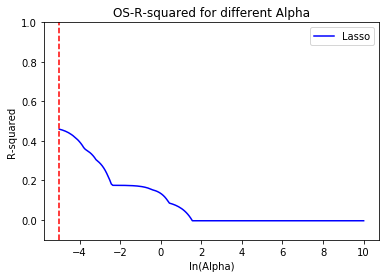

0.006737946999085467

In [19]:
alphas = np.exp(np.linspace(-5,10,200)) #exponential range of possible alphas

[alpha_optimal, best_R2, Lasso_coefs] = Regularization_fit_alpha(2,
                                                                 trainx, trainy,
                                                                 validx, validy,
                                                                 alphas,
                                                                 Graph=True, logl=True)
alpha_optimal

In [20]:
Lasso = linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(trainx, trainy)
# In sample:
YPred_IS=Lasso.predict(trainx)
print("The IS R-squared of Lasso is: {0}".format(r2_score(trainy, YPred_IS)))

Lasso.coef_

The IS R-squared of Lasso is: 0.4299450616488203


array([-3.40401206e-03,  4.39733692e-04,  5.22140580e-03, -0.00000000e+00,
        3.38290809e-03,  6.08851048e-02,  2.19094962e-01, -2.18687696e-15,
       -3.89380843e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.13162508e-01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.61342749e-01,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -1.40104519e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.62476191e-01, -0.00000000e+00,
        6.24927874e-03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.67771051e-02,  0.00000000e+00, -0.00000000e+00,
       -9.90942735e-03])

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

min_samples_leaf = [1, 2, 5, 10] 
min_samples_split = [2, 4, 10, 12, 16]
n_estimators = [50, 100, 400, 700, 1000]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
               'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
               
              }

param_grid = { 
    "criterion" : ["gini", "entropy"], 
    "min_samples_leaf" : [1, 5, 10], 
    "min_samples_split" : [2, 4, 10, 12, 16],
#     "n_estimators": n_estimators,
    'max_leaf_nodes': range(2,20)
}

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

forest = RandomForestClassifier()
ft_grid = GridSearchCV(estimator = forest, 
                       param_grid = param_grid,
                       scoring = 'accuracy',
                       cv=3,
                       n_jobs= -1
                      )

ft_tuned = ft_grid.fit(train[cols], train[['Survived']].values.ravel())

In [69]:
print ("Best score: ", ft_tuned.best_score_) # 0.840628507295174
print ("Best params: ", ft_tuned.best_params_)
print ("IS Score: ", ft_tuned.score(train[cols], train[['Survived']])) # 0.8698092031425365

Best score:  0.8350168350168351
Best params:  {'criterion': 'gini', 'max_leaf_nodes': 19, 'min_samples_leaf': 5, 'min_samples_split': 4}
IS Score:  0.8630751964085297


In [71]:
rf = RandomForestClassifier(criterion = ft_tuned.best_params_['criterion'], 
#                              n_estimators = ft_tuned.best_params_['n_estimators'],
                             min_samples_split = ft_tuned.best_params_['min_samples_split'],
                             min_samples_leaf = ft_tuned.best_params_['min_samples_leaf'],
                             max_leaf_nodes = ft_tuned.best_params_['max_leaf_nodes'],
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train[cols], train[['Survived']].values.ravel())
print("%.4f" % rf.oob_score_) # 0.8339

pd.concat((pd.DataFrame(cols, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

0.8350


,variable,importance
9,Sex_male,0.173145
20,title_Mr.,0.149107
8,Sex_female,0.127029
1,Fare,0.071679
2,name_len,0.054510
15,Pclass_3,0.051440
0,Age,0.043962
16,title_Miss.,0.042248
25,cabin_letter_n,0.039113
22,title_Mrs.,0.033737


In [72]:
pred_test = ft_tuned.predict(test[cols])
pred_test

#PassengerId,Survived
test_res = test[["PassengerId"]].copy()
test_res["Survived"] = pred_test
test_res.to_csv("my_predictions.csv", index=False)
test_res.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
